# Description

Link [here](https://www.kaggle.com/c/nlp-getting-started/overview)

# Contents

# Getting Data From Kaggle via API <a name="getting-kaggle-data"></a>

In [ ]:
! pip install -q kaggle

In [ ]:
import os

os.chdir('/content/drive/MyDrive/Hackerearth/Disaster Tweet')
os.getcwd()

'/content/drive/MyDrive/Hackerearth/Disaster Tweet'

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d vstepanenko/disaster-tweets

  0% 0.00/656k [00:00<?, ?B/s]
100% 656k/656k [00:00<00:00, 44.0MB/s]


In [ ]:
! unzip disaster-tweets.zip

Archive:  disaster-tweets.zip
  inflating: tweets.csv              


# Play Around with data <a name="play-with-data"></a>

### Explore Data

In [79]:
WORKING_DIR = '/content/drive/MyDrive/Hackerearth/Disaster Tweet'

import os
os.chdir(WORKING_DIR)

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [80]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn
import torchtext
import matplotlib.pyplot as plt


In [81]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [82]:
# imbalanced dataset, more negative samples than positive samples

df.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


In [83]:
len(df['keyword'].unique()), len(df)

(222, 7613)

### Preprocessing using torchtext

In [84]:
from torchtext import data  

In [85]:
import re
import string 

def clean_text(text):
    text = text.lower()
    #foction de replacement
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[-()\"#/@;:<>{}=~|.?!,]", "", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [86]:
df['text'] = df['text'].map(clean_text)

df.to_csv('cleaned tweets.csv', index=False)

In [87]:
# Denotes the transformatioin to be applied

Text = data.Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True)
Labels = data.LabelField(dtype=torch.float, batch_first=True)

In [88]:
# which cols to consider and how, in the dataset, and which transformation to apply

fields = {'text': ('text', Text), 'target': ('label', Labels)}

In [89]:
# loading custom dataset
training_data=data.TabularDataset(path = 'cleaned tweets.csv',format = 'csv',fields = fields)

In [90]:
import random
# for now, random split, will look for ways to stratify the split
train_data, valid_data = training_data.split(split_ratio=0.7)

In [91]:
# build vocabulary

Text.build_vocab(train_data,min_freq=3)  
Labels.build_vocab(train_data)

In [92]:
# No. of unique tokens in text
print("Size of TEXT vocabulary:",len(Text.vocab))

# No. of unique tokens in label
print("Size of LABEL vocabulary:",len(Labels.vocab))

# Commonly used words
print(Text.vocab.freqs.most_common(10))  

# Word dictionary
# print(Text.vocab.stoi) 

# Data cleaning required !!

Size of TEXT vocabulary: 3337
Size of LABEL vocabulary: 2
[(' ', 3639), ('the', 2248), ('a', 1534), ('in', 1384), ('to', 1367), ('i', 1272), ('of', 1270), ('is', 1214), ('and', 1016), ('you', 632)]


In [93]:
for x in train_data:
    print(x.text)
    break

[' ', 'years', 'ago', 'this', 'week', 'is', 'the', 'anniversary', 'of', 'marilyn', 'monroe', 'is', 'death', 'ripriprip']


In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 128

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [95]:
device

device(type='cuda')

In [96]:

for batch in train_iterator:
    print(batch.text.shape, batch.text)
    # [batch_size, max_length_of_sentence_in_batch]
    break

torch.Size([128, 14]) tensor([[  67,  151,   13,  ...,  703,   62,  366],
        [   0,    5,    2,  ...,  203,    0,    2],
        [ 867, 2155,  309,  ...,  106,    2,    0],
        ...,
        [   7,   33,  147,  ...,    0,  437,  715],
        [ 513,    9,  438,  ...,    2,    0,    0],
        [   0,  864,    2,  ...,   21,    3, 1895]], device='cuda:0')


## Training Starts

In [97]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn

### Define model

In [98]:
class Rnn(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, batch_size, n_layers=1):
        super(Rnn, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=0.2, batch_first=True)
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 2)
        
    def forward(self, src):
        
        #src = [src len, batch size] or [batch size, seq len]
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        hidden = torch.squeeze(hidden, 0)
        x = self.relu(self.norm(hidden))
        return self.fc(self.dropout(x))

In [99]:
model = Rnn(input_dim=len(Text.vocab), embed_dim=100, hidden_dim=50, batch_size=BATCH_SIZE)
model = model.to(device)

In [100]:
optimizer = torch.optim.Adam(model.parameters())
criterian = nn.CrossEntropyLoss().to(device)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, patience=3, threshold=0.01, verbose=True)

### Train

In [101]:
dataIterator = {
    'train': train_iterator,
    'val': valid_iterator
}

In [102]:
from tqdm.autonotebook import tqdm
logs = {
	'loss': {
		'train': [],
		'val': []
	},
	'acc': {
		'train': [],
		'val': []
	}
}

for epoch in range(40):
	print('='*20, 'Epoch: ', epoch+1, '='*20)
	for phase in ['train', 'val']:
		running_loss = 0.0
		running_accuracy = 0.0
		for batch in tqdm(dataIterator[phase], leave=False, position=0):
			inputs, labels = batch.text, batch.label.long()
			out = model(batch.text) # ; print(batch.text); break
			# print('Debug: ', out.shape, labels.shape, out[0])

			loss = criterian(out, labels)

			if phase == 'train':
				loss.backward()
				optimizer.step()

			out = torch.argmax(out, 1)
			running_loss += loss.item() * inputs.shape[0]
			running_accuracy += torch.sum(labels == out)

		if phase == 'train':
			scheduler.step(running_loss)
		running_accuracy /= len(train_data) if phase == 'train' else len(valid_data)
		running_loss /= len(train_data) if phase == 'train' else len(valid_data)

		logs['loss'][phase].append(running_loss)
		logs['acc'][phase].append(running_accuracy)

		print(f'[{phase}] Running Loss: {running_loss :.2f}, Accuracy: {running_accuracy : .2f}')


==================== Epoch:  1 ====================


[train] Running Loss: 0.70, Accuracy:  0.56


[val] Running Loss: 0.67, Accuracy:  0.60
==================== Epoch:  2 ====================


[train] Running Loss: 0.66, Accuracy:  0.62


[val] Running Loss: 0.63, Accuracy:  0.66
==================== Epoch:  3 ====================


[train] Running Loss: 0.62, Accuracy:  0.69


[val] Running Loss: 0.66, Accuracy:  0.70
==================== Epoch:  4 ====================


[train] Running Loss: 0.50, Accuracy:  0.78


[val] Running Loss: 0.61, Accuracy:  0.70
==================== Epoch:  5 ====================


[train] Running Loss: 0.46, Accuracy:  0.79


[val] Running Loss: 0.60, Accuracy:  0.72
==================== Epoch:  6 ====================


[train] Running Loss: 0.38, Accuracy:  0.83


[val] Running Loss: 0.67, Accuracy:  0.75
==================== Epoch:  7 ====================


[train] Running Loss: 0.34, Accuracy:  0.86


[val] Running Loss: 0.74, Accuracy:  0.75
==================== Epoch:  8 ====================


[train] Running Loss: 0.30, Accuracy:  0.88


[val] Running Loss: 0.75, Accuracy:  0.75
==================== Epoch:  9 ====================


[train] Running Loss: 0.26, Accuracy:  0.89


[val] Running Loss: 0.72, Accuracy:  0.74
==================== Epoch:  10 ====================


[train] Running Loss: 0.25, Accuracy:  0.89


[val] Running Loss: 0.74, Accuracy:  0.74
==================== Epoch:  11 ====================


[train] Running Loss: 0.24, Accuracy:  0.90


[val] Running Loss: 0.78, Accuracy:  0.73
==================== Epoch:  12 ====================


[train] Running Loss: 0.22, Accuracy:  0.91


[val] Running Loss: 0.91, Accuracy:  0.73
==================== Epoch:  13 ====================


[train] Running Loss: 0.22, Accuracy:  0.91


[val] Running Loss: 1.05, Accuracy:  0.73
==================== Epoch:  14 ====================


[train] Running Loss: 0.20, Accuracy:  0.93


[val] Running Loss: 1.15, Accuracy:  0.74
==================== Epoch:  15 ====================


[train] Running Loss: 0.19, Accuracy:  0.92


[val] Running Loss: 1.13, Accuracy:  0.74
==================== Epoch:  16 ====================


[train] Running Loss: 0.19, Accuracy:  0.92


[val] Running Loss: 1.16, Accuracy:  0.74
==================== Epoch:  17 ====================


[train] Running Loss: 0.18, Accuracy:  0.92


[val] Running Loss: 1.13, Accuracy:  0.73
==================== Epoch:  18 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.13, Accuracy:  0.74
==================== Epoch:  19 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.11, Accuracy:  0.75
==================== Epoch:  20 ====================


[train] Running Loss: 0.18, Accuracy:  0.93


[val] Running Loss: 1.18, Accuracy:  0.73
==================== Epoch:  21 ====================


[train] Running Loss: 0.18, Accuracy:  0.92


[val] Running Loss: 1.20, Accuracy:  0.72
==================== Epoch:  22 ====================


Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
[train] Running Loss: 0.19, Accuracy:  0.92


[val] Running Loss: 1.29, Accuracy:  0.72
==================== Epoch:  23 ====================


[train] Running Loss: 0.18, Accuracy:  0.92


[val] Running Loss: 1.32, Accuracy:  0.73
==================== Epoch:  24 ====================


[train] Running Loss: 0.18, Accuracy:  0.93


[val] Running Loss: 1.33, Accuracy:  0.74
==================== Epoch:  25 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.34, Accuracy:  0.73
==================== Epoch:  26 ====================


Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.35, Accuracy:  0.72
==================== Epoch:  27 ====================


[train] Running Loss: 0.16, Accuracy:  0.94


[val] Running Loss: 1.25, Accuracy:  0.74
==================== Epoch:  28 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.34, Accuracy:  0.75
==================== Epoch:  29 ====================


[train] Running Loss: 0.17, Accuracy:  0.94


[val] Running Loss: 1.33, Accuracy:  0.74
==================== Epoch:  30 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.35, Accuracy:  0.73
==================== Epoch:  31 ====================


Epoch    31: reducing learning rate of group 0 to 1.0000e-06.
[train] Running Loss: 0.18, Accuracy:  0.93


[val] Running Loss: 1.30, Accuracy:  0.73
==================== Epoch:  32 ====================


[train] Running Loss: 0.16, Accuracy:  0.94


[val] Running Loss: 1.34, Accuracy:  0.74
==================== Epoch:  33 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.34, Accuracy:  0.74
==================== Epoch:  34 ====================


[train] Running Loss: 0.16, Accuracy:  0.93


[val] Running Loss: 1.33, Accuracy:  0.74
==================== Epoch:  35 ====================


Epoch    35: reducing learning rate of group 0 to 1.0000e-07.
[train] Running Loss: 0.18, Accuracy:  0.93


[val] Running Loss: 1.32, Accuracy:  0.74
==================== Epoch:  36 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.34, Accuracy:  0.73
==================== Epoch:  37 ====================


[train] Running Loss: 0.16, Accuracy:  0.93


[val] Running Loss: 1.32, Accuracy:  0.74
==================== Epoch:  38 ====================


[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.34, Accuracy:  0.73
==================== Epoch:  39 ====================


Epoch    39: reducing learning rate of group 0 to 1.0000e-08.
[train] Running Loss: 0.17, Accuracy:  0.93


[val] Running Loss: 1.31, Accuracy:  0.73
==================== Epoch:  40 ====================


[train] Running Loss: 0.16, Accuracy:  0.93


[val] Running Loss: 1.31, Accuracy:  0.73


In [103]:
len(train_data), len(valid_data), len(df)

(5329, 2284, 7613)

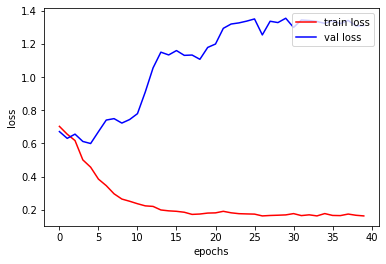

In [104]:
import matplotlib.pyplot as plt

plt.plot(logs['loss']['train'], color='red', label='train loss')
plt.plot(logs['loss']['val'], color='blue', label='val loss')
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Predict

In [147]:
# Denotes the transformatioin to be applied

Text = data.Field(sequential=True, use_vocab=True, tokenize='spacy', batch_first=True)
Labels = data.LabelField(dtype=torch.int64, batch_first=True, use_vocab=False)

In [148]:
fields = {'text': ('text', Text), 'id': ('id', Labels)}

In [149]:
test_data=data.TabularDataset(path = 'test.csv',format = 'csv',fields = fields)
Text.build_vocab(test_data,min_freq=3)  
Labels.build_vocab(test_data)

In [150]:
Labels.vocab.itos[2], Text.vocab.itos[2]

('10002', '#')

In [151]:
# Commonly used words
# print(Text.vocab.freqs.most_common(10))  

In [152]:
for x in test_data:
    print(x.text, x.id)
    break

['Just', 'happened', 'a', 'terrible', 'car', 'crash'] 0


In [153]:
# Labels.vocab.freqs.most_common(3)
# Labels.vocab.

In [154]:
#Load an iterator
test_iterator = data.BucketIterator(
    test_data, 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [155]:
# list(test_data)
cnt = 10
for _, x in zip(list(range(cnt)), test_data):
    print(x.text, x.id)
    # out = model(x.text)
    # print(out)
    # break

['Just', 'happened', 'a', 'terrible', 'car', 'crash'] 0
['Heard', 'about', '#', 'earthquake', 'is', 'different', 'cities', ',', 'stay', 'safe', 'everyone', '.'] 2
['there', 'is', 'a', 'forest', 'fire', 'at', 'spot', 'pond', ',', 'geese', 'are', 'fleeing', 'across', 'the', 'street', ',', 'I', 'can', 'not', 'save', 'them', 'all'] 3
['Apocalypse', 'lighting', '.', '#', 'Spokane', '#', 'wildfires'] 9
['Typhoon', 'Soudelor', 'kills', '28', 'in', 'China', 'and', 'Taiwan'] 11
['We', "'re", 'shaking', '...', 'It', "'s", 'an', 'earthquake'] 12
['They', "'d", 'probably', 'still', 'show', 'more', 'life', 'than', 'Arsenal', 'did', 'yesterday', ',', 'eh', '?', 'EH', '?'] 21
['Hey', '!', 'How', 'are', 'you', '?'] 22
['What', 'a', 'nice', 'hat', '?'] 27
['Fuck', 'off', '!'] 29


In [156]:
for x in test_iterator:
    # print(x.text, x.id)
    # print(x.id, x.id.shape)
    out = model(x.text)
    print(out[:5])
    out = torch.argmax(out, dim=1)
    print(out[:5])
    break

tensor([[-3.3929,  3.9772],
        [ 0.5122, -0.3056],
        [ 3.1278, -3.1414],
        [ 3.0021, -2.9524],
        [ 8.3567, -8.6517]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([1, 0, 0, 0, 0], device='cuda:0')


In [157]:
preds = pd.DataFrame(columns=['id', 'target'])

In [158]:
model.eval()

for batch in test_iterator:
    inputs, ids = batch.text.cuda(), batch.id
    outs = model(inputs)
    outs = torch.argmax(outs, dim=1)

    for out, id in zip(outs, ids):
        preds = preds.append({'id': id.item(), 'target': Labels.vocab.itos[out.item()]}, ignore_index=True)

In [159]:
preds.head()

,id,target
0,8290,0
1,10216,0
2,7786,0
3,3974,0
4,3254,0


In [160]:
len(preds), len(test_data)

(3263, 3263)

In [161]:
preds.to_csv('preds.csv', index=False)

In [162]:
org = set(pd.read_csv('test.csv')['id'])
org == set(preds['id']), len(org - set(preds['id']))

(True, 0)

In [163]:
{'Rank': 1152, 'score': 0.352}

{'Rank': 1152, 'score': 0.352}

### Improvements

- clean the data, remove [. , # ] etc
- split the dataset such that train and test labels have same positive and negative

In [ ]:
# ! unzip nlp-getting-started.zip